In [129]:
#!/usr/bin/python3
# coding: utf-8
# prefectures

In [130]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib
import sys
if "ipy" not in sys.argv[0]:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from japanmap import picture
import numpy as np
import os
import pandas as pd
from PIL import Image
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed, json2nparr, code2int, age2int

In [131]:
populations = {}
all_population = 0
with codecs.open("population.txt", encoding='utf-8') as f:
    l = f.readline()
    while l:
        elems = l.split(',')
        populations[elems[3]] = dict(
            region = int(elems[0]),
            code   = int(elems[1]),
            ja     = elems[2],
            en     = elems[3],
            total = int(elems[4])
        )
        all_population += int(elems[4])
        l = f.readline().replace("\r\n", "").rstrip()
print("All population in Japan: {}".format(all_population))

All population in Japan: 127094745


In [132]:
#print(populations)

In [133]:
# 全国情報
ogiwara_uri = "https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/"
pref_file = "prefectures.csv"
download_if_needed(ogiwara_uri, pref_file)

In [134]:
offsets = dict(
    year  = 0, # 年
    month = 1, # 月
    day   = 2, # 日
    st_ja = 3, # 都道府県
    st_en = 4, # state
    posis = 5, # 陽性者数
    tests = 6, # 検査数
    hospi = 7, # hospitalized
    serio = 8, # serious
    disch = 9, # discharged
    death =10, # deaths
    ern   =11, # Effective Reproduction Number
)

In [135]:
dt_start = dt.strptime("2020/2/8", "%Y/%m/%d") # 統計開始日
dt_now   = dt.now() # 現在日時
dt_delta = (dt_now - dt_start).days # 差分
n_states = 47 # 都道府県数
erns = [] # ERN 
poss = [] # positives
for i in np.arange(dt_delta):
    erns.append(np.zeros(n_states+1).tolist())
    poss.append(np.zeros(n_states+1).tolist())
    poss[i][0] = erns[i][0] = i

In [136]:
with codecs.open("prefectures.csv", encoding='utf-8') as f:
    l = f.readline()
    cnt = 0
    while l:
        l = f.readline().replace("\r\n", "").rstrip()
        elems = l.split(',')
        if len(elems) < 2:
            continue
        dt_idx  = (dt(int(elems[0]), int(elems[1]), int(elems[2])) - dt_start).days
        st_name = elems[offsets['st_en']]
        st_idx  = populations[st_name]['code']
        erns[dt_idx][st_idx] = blank2zero(elems[offsets['ern']])
        poss[dt_idx][st_idx] = blank2zero(elems[offsets['posis']])
        cnt += 1
print("Load {} lines.".format(cnt))

Load 9819 lines.


In [137]:
erns = np.array(erns)
poss = np.array(poss)
os_idx = -1
for i in np.arange(dt_delta):
    if np.sum(poss[-i -1, 1:])  > 0:
        os_idx = -i -1
        print("Data offset index: {}".format(os_idx))
        break

latest_erns = erns[os_idx] # 最新の実効再生産数
print("latest_erns", latest_erns)
latest_poss = poss[os_idx] # 最新の陽性者数
last1w_poss = poss[os_idx -  7] # 1週間前の陽性者数
last2w_poss = poss[os_idx - 14] # 2週間前の陽性者数
diff1w_poss = latest_poss - last1w_poss # 最新と1週間前の差分
diff2w_poss = latest_poss - last2w_poss # 最新と2週間前の差分
print("diff1w_poss", diff1w_poss[1:])
print("diff2w_poss", diff2w_poss[1:])
# 都道府県別 罹患率
incid1w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (1週足)
incid2w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (2週足)
for k, v in populations.items():
    i = v['code']
    incid1w_rate[i] = (diff1w_poss[i] / v['total']) * 100 # percentage
    incid2w_rate[i] = (diff2w_poss[i] / v['total']) * 100 # percentage
# 簡易罹患率
print("incid1w_rate", incid1w_rate[1:])
print("incid2w_rate", incid2w_rate[1:])

Data offset index: -2
latest_erns [238.     1.03   0.     0.     0.98   0.     0.     0.91   1.88   0.31
   0.61   1.45   1.17   1.13   1.12   0.     3.16   0.29   0.     0.
   2.93   0.68   2.07   1.03   1.52   1.     1.08   0.95   1.34   1.52
   1.64   0.     0.     1.34   2.16   3.16   0.     0.     0.     0.
   1.5    0.     0.     7.25   0.     0.     0.94   1.84]
diff1w_poss [1.090e+02 2.000e+00 0.000e+00 3.300e+01 0.000e+00 0.000e+00 2.100e+01
 3.400e+01 8.000e+00 2.700e+01 2.180e+02 2.260e+02 1.266e+03 4.200e+02
 0.000e+00 1.000e+01 4.000e+00 0.000e+00 1.300e+01 9.000e+00 1.100e+01
 2.500e+01 1.860e+02 3.600e+01 1.300e+01 5.700e+01 3.710e+02 1.310e+02
 1.800e+01 4.000e+00 0.000e+00 0.000e+00 6.000e+00 9.100e+01 5.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 3.700e+01 1.000e+00 2.000e+00
 1.600e+01 0.000e+00 0.000e+00 2.200e+01 1.620e+02]
diff2w_poss [2.14e+02 2.00e+00 0.00e+00 6.70e+01 1.00e+00 0.00e+00 4.50e+01 4.80e+01
 5.00e+01 8.10e+01 3.48e+02 4.08e+02 2.33e+03 7.77e+0

In [138]:
def create_basic_scatter_figure(xlabel, ylabel):
    """ 基本散布図テンプレートを作成する """
    plt.close()
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    plt.xlabel(xlabel, fontname=FONT_NAME)
    plt.ylabel(ylabel, fontname=FONT_NAME)
    plt.grid(True)
    plt.subplots_adjust(left=0.07, right=0.97, bottom=0.07, top=0.97)
    return fig, ax

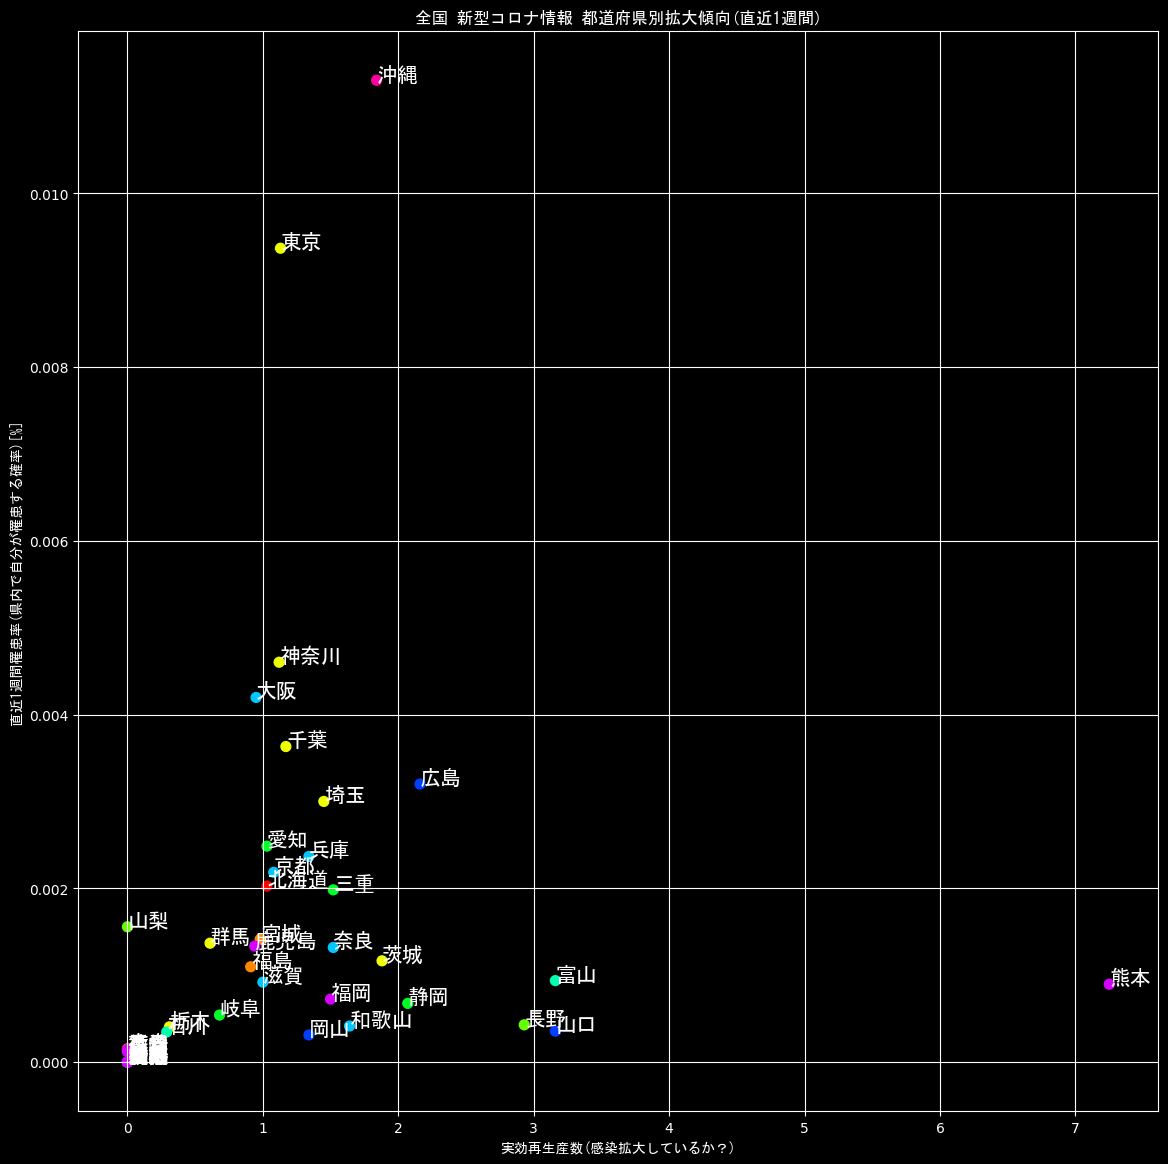

In [139]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近1週間罹患率(県内で自分が罹患する確率)[%]")
cols = [ "#ff0000" for i in range(n_states)]
texts = [ "?" for i in range(n_states)]
for k, v in populations.items():
    cols[v['code'] - 1]  = cm.hsv(v['region'] / 11)
    texts[v['code'] - 1] = v['ja']
plt.scatter(latest_erns[1:], incid1w_rate[1:], s=50, c=cols)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid1w_rate[1 + i]), size=15, fontname=FONT_NAME)
tw_body_1w = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)'
plt.title(tw_body_1w, fontname=FONT_NAME)
show_and_clear(fig, "ern-1w_poss.jpg")

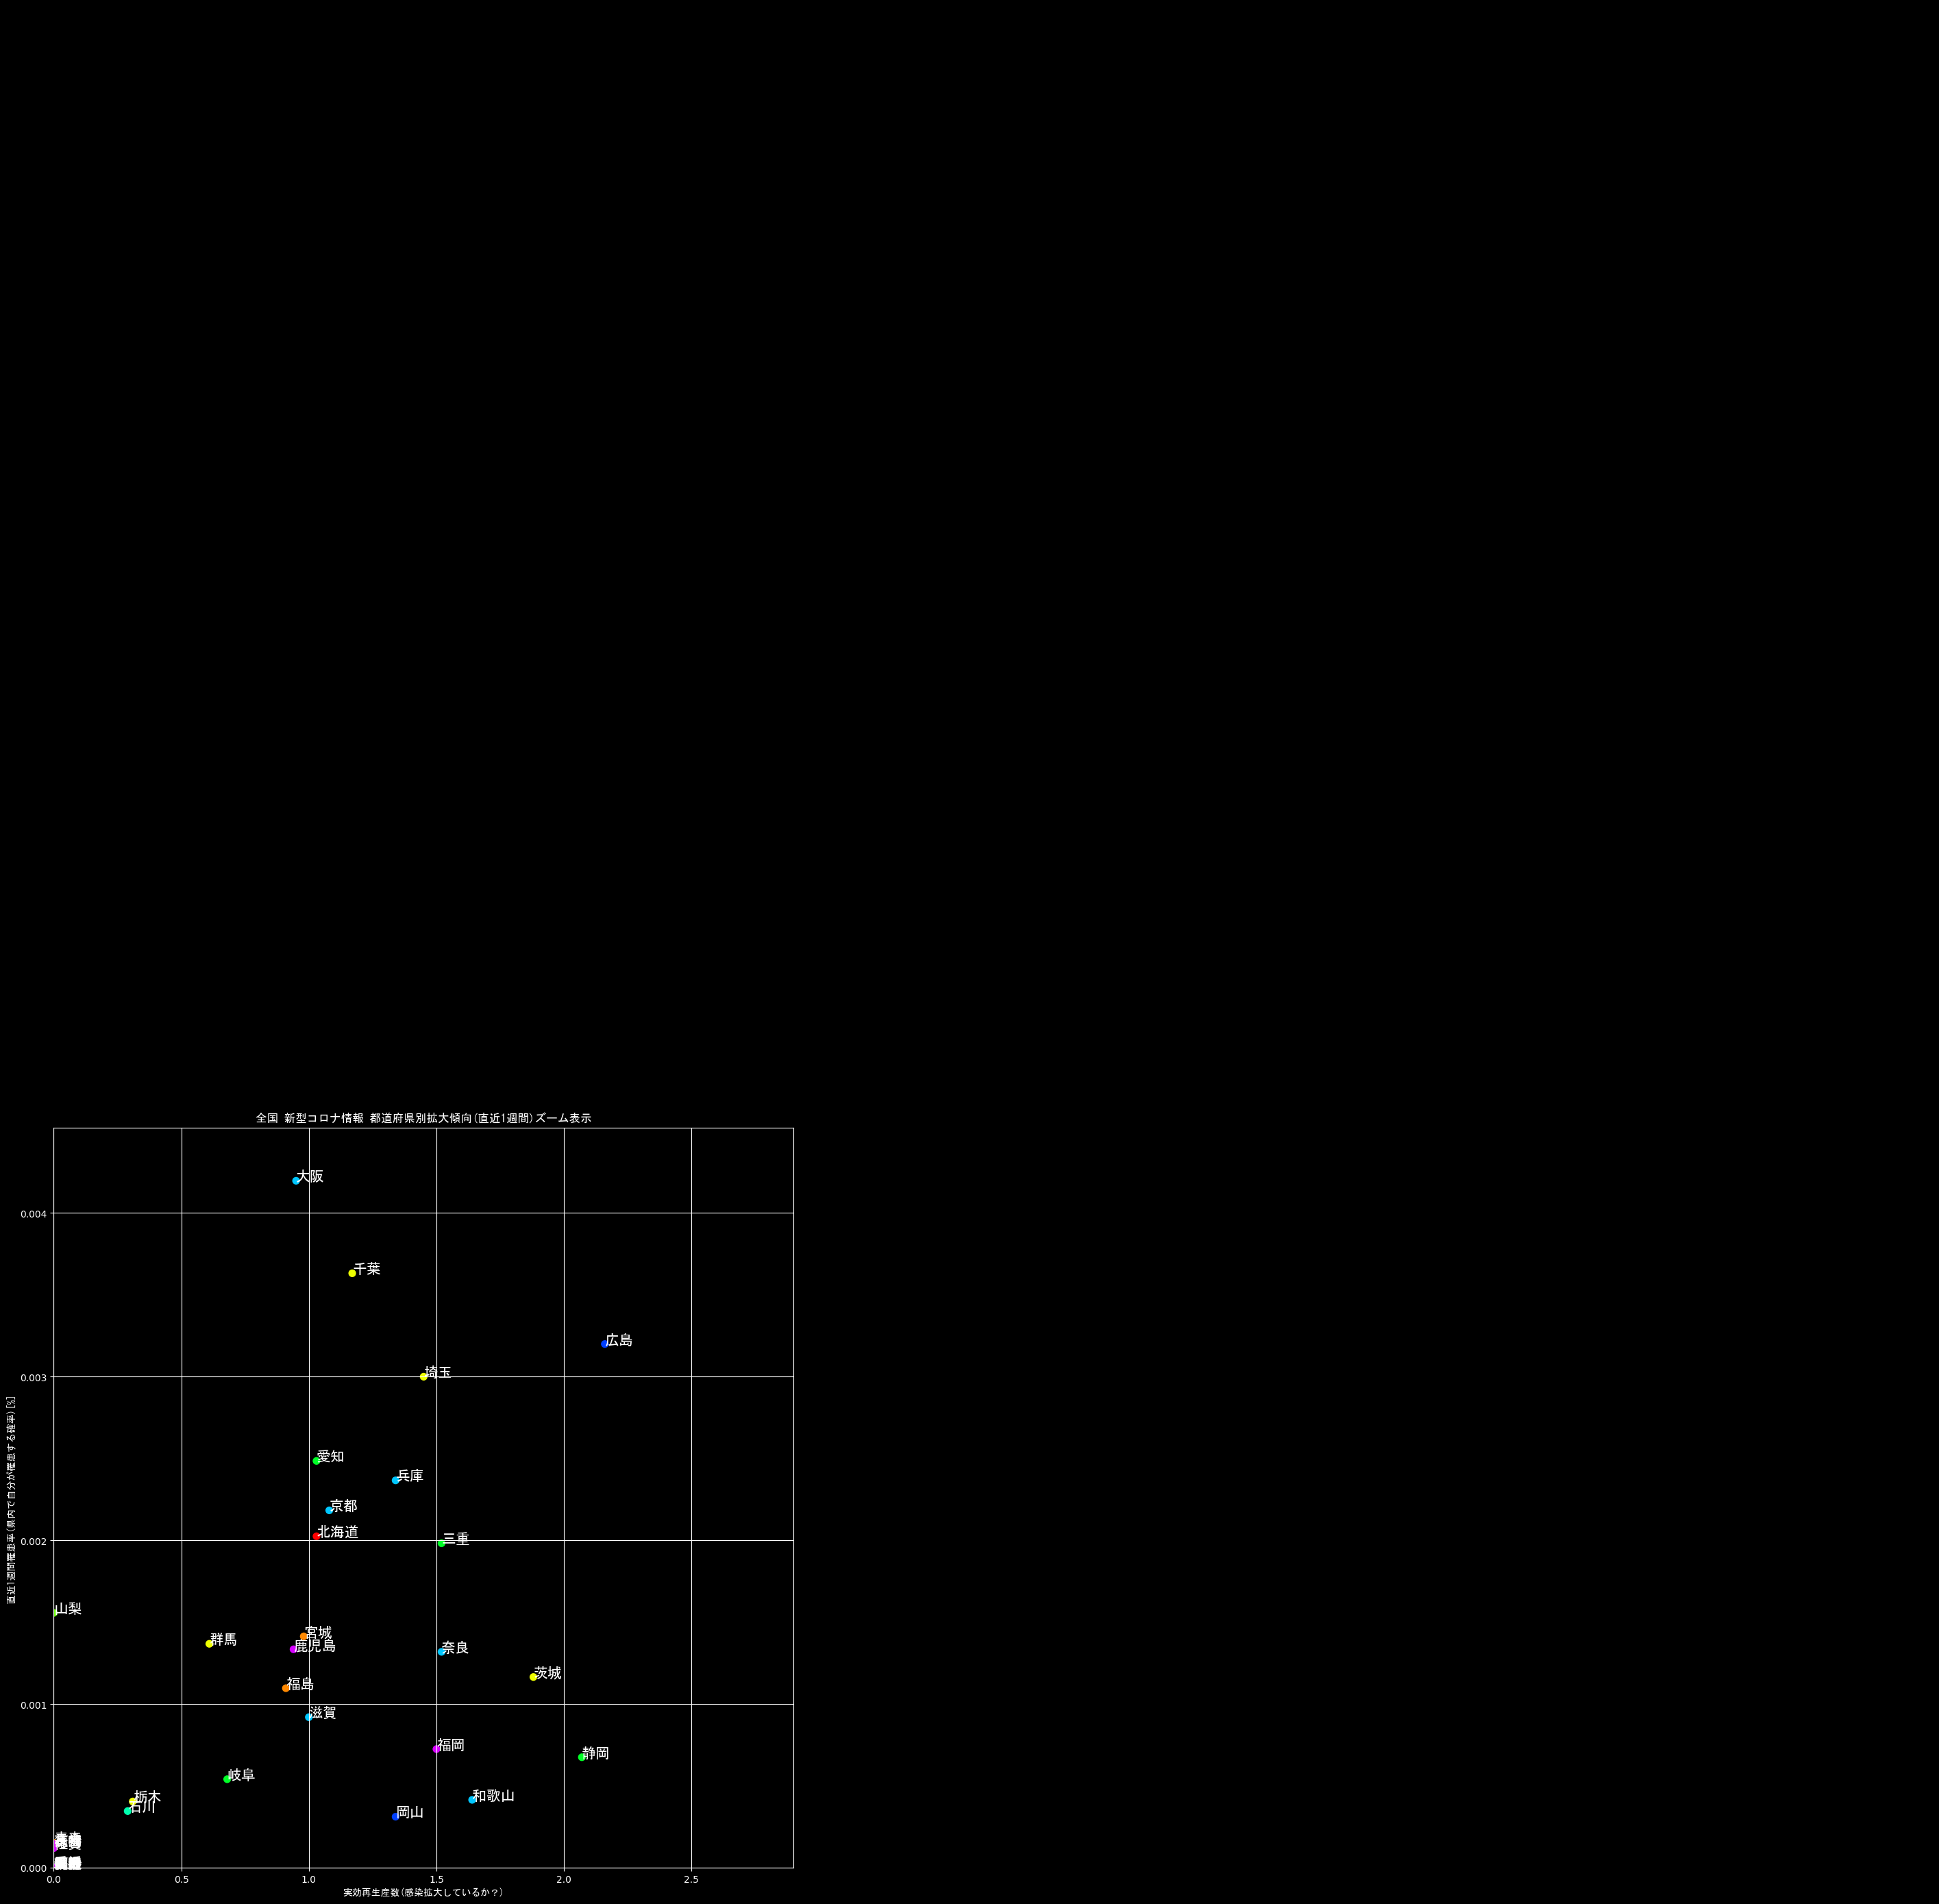

In [141]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近1週間罹患率(県内で自分が罹患する確率)[%]")
plt.xlim(0, np.max(latest_erns[1:]) * 0.4)
plt.ylim(0, np.max(incid1w_rate[1:]) * 0.4)
plt.scatter(latest_erns[1:], incid1w_rate[1:], s=50, c=cols)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid1w_rate[1 + i]), size=15, fontname=FONT_NAME)
tw_body_1w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)ズーム表示'
plt.title(tw_body_1w_zoom, fontname=FONT_NAME)
show_and_clear(fig, "ern-1w_poss-zoom.jpg")

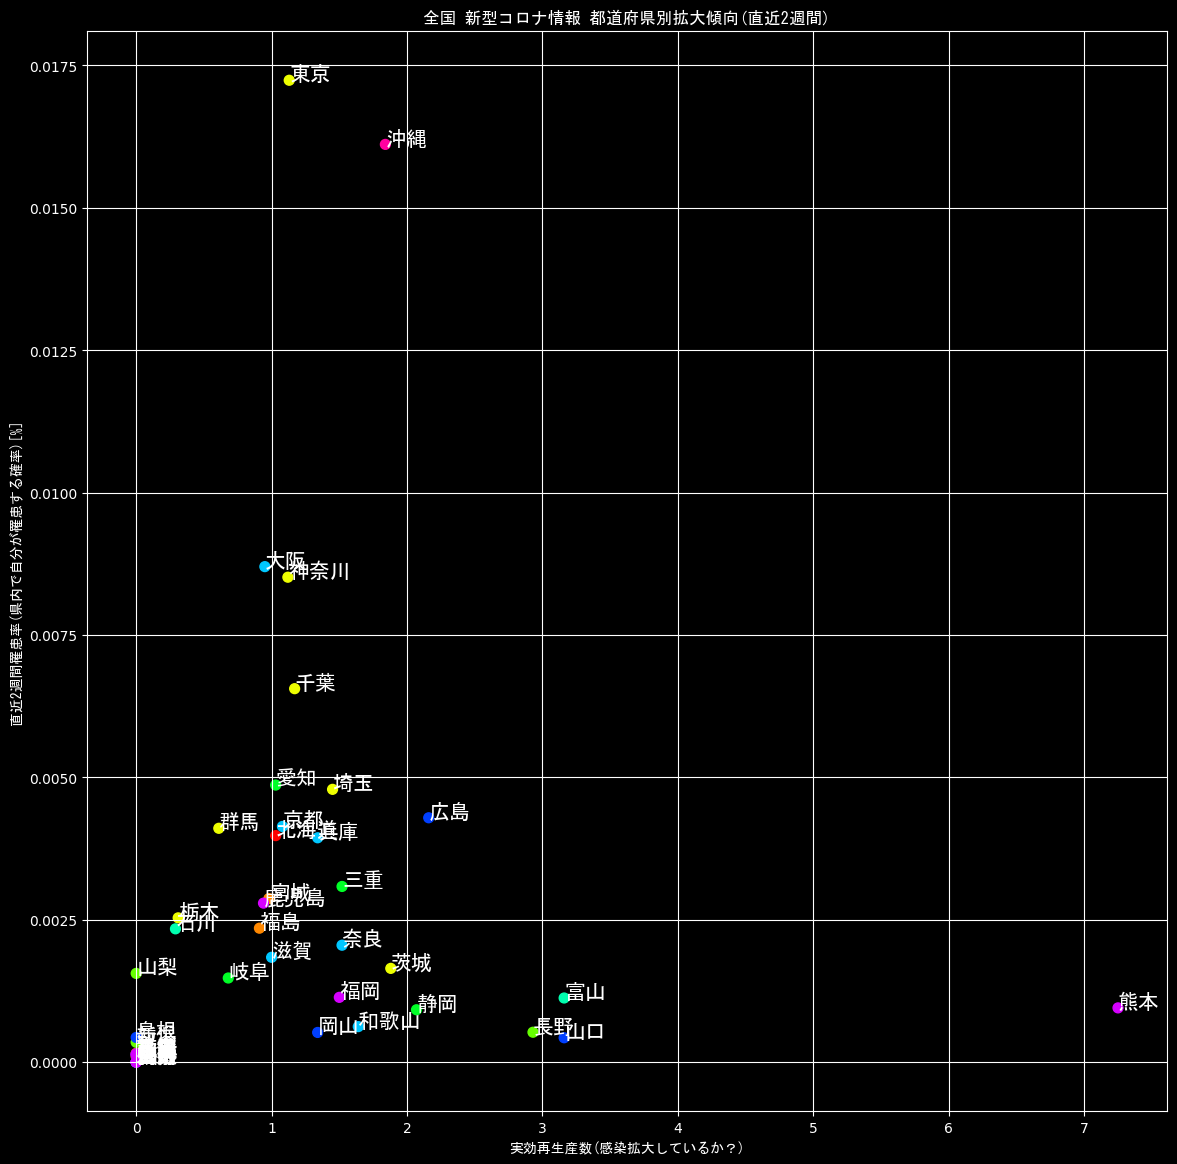

In [142]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近2週間罹患率(県内で自分が罹患する確率)[%]")
plt.scatter(latest_erns[1:], incid2w_rate[1:], s=50, c=cols)
tw_body_2w = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)'
plt.title(tw_body_2w, fontname=FONT_NAME)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid2w_rate[1 + i]), size=15, fontname=FONT_NAME)
show_and_clear(fig, "ern-2w_poss.jpg")

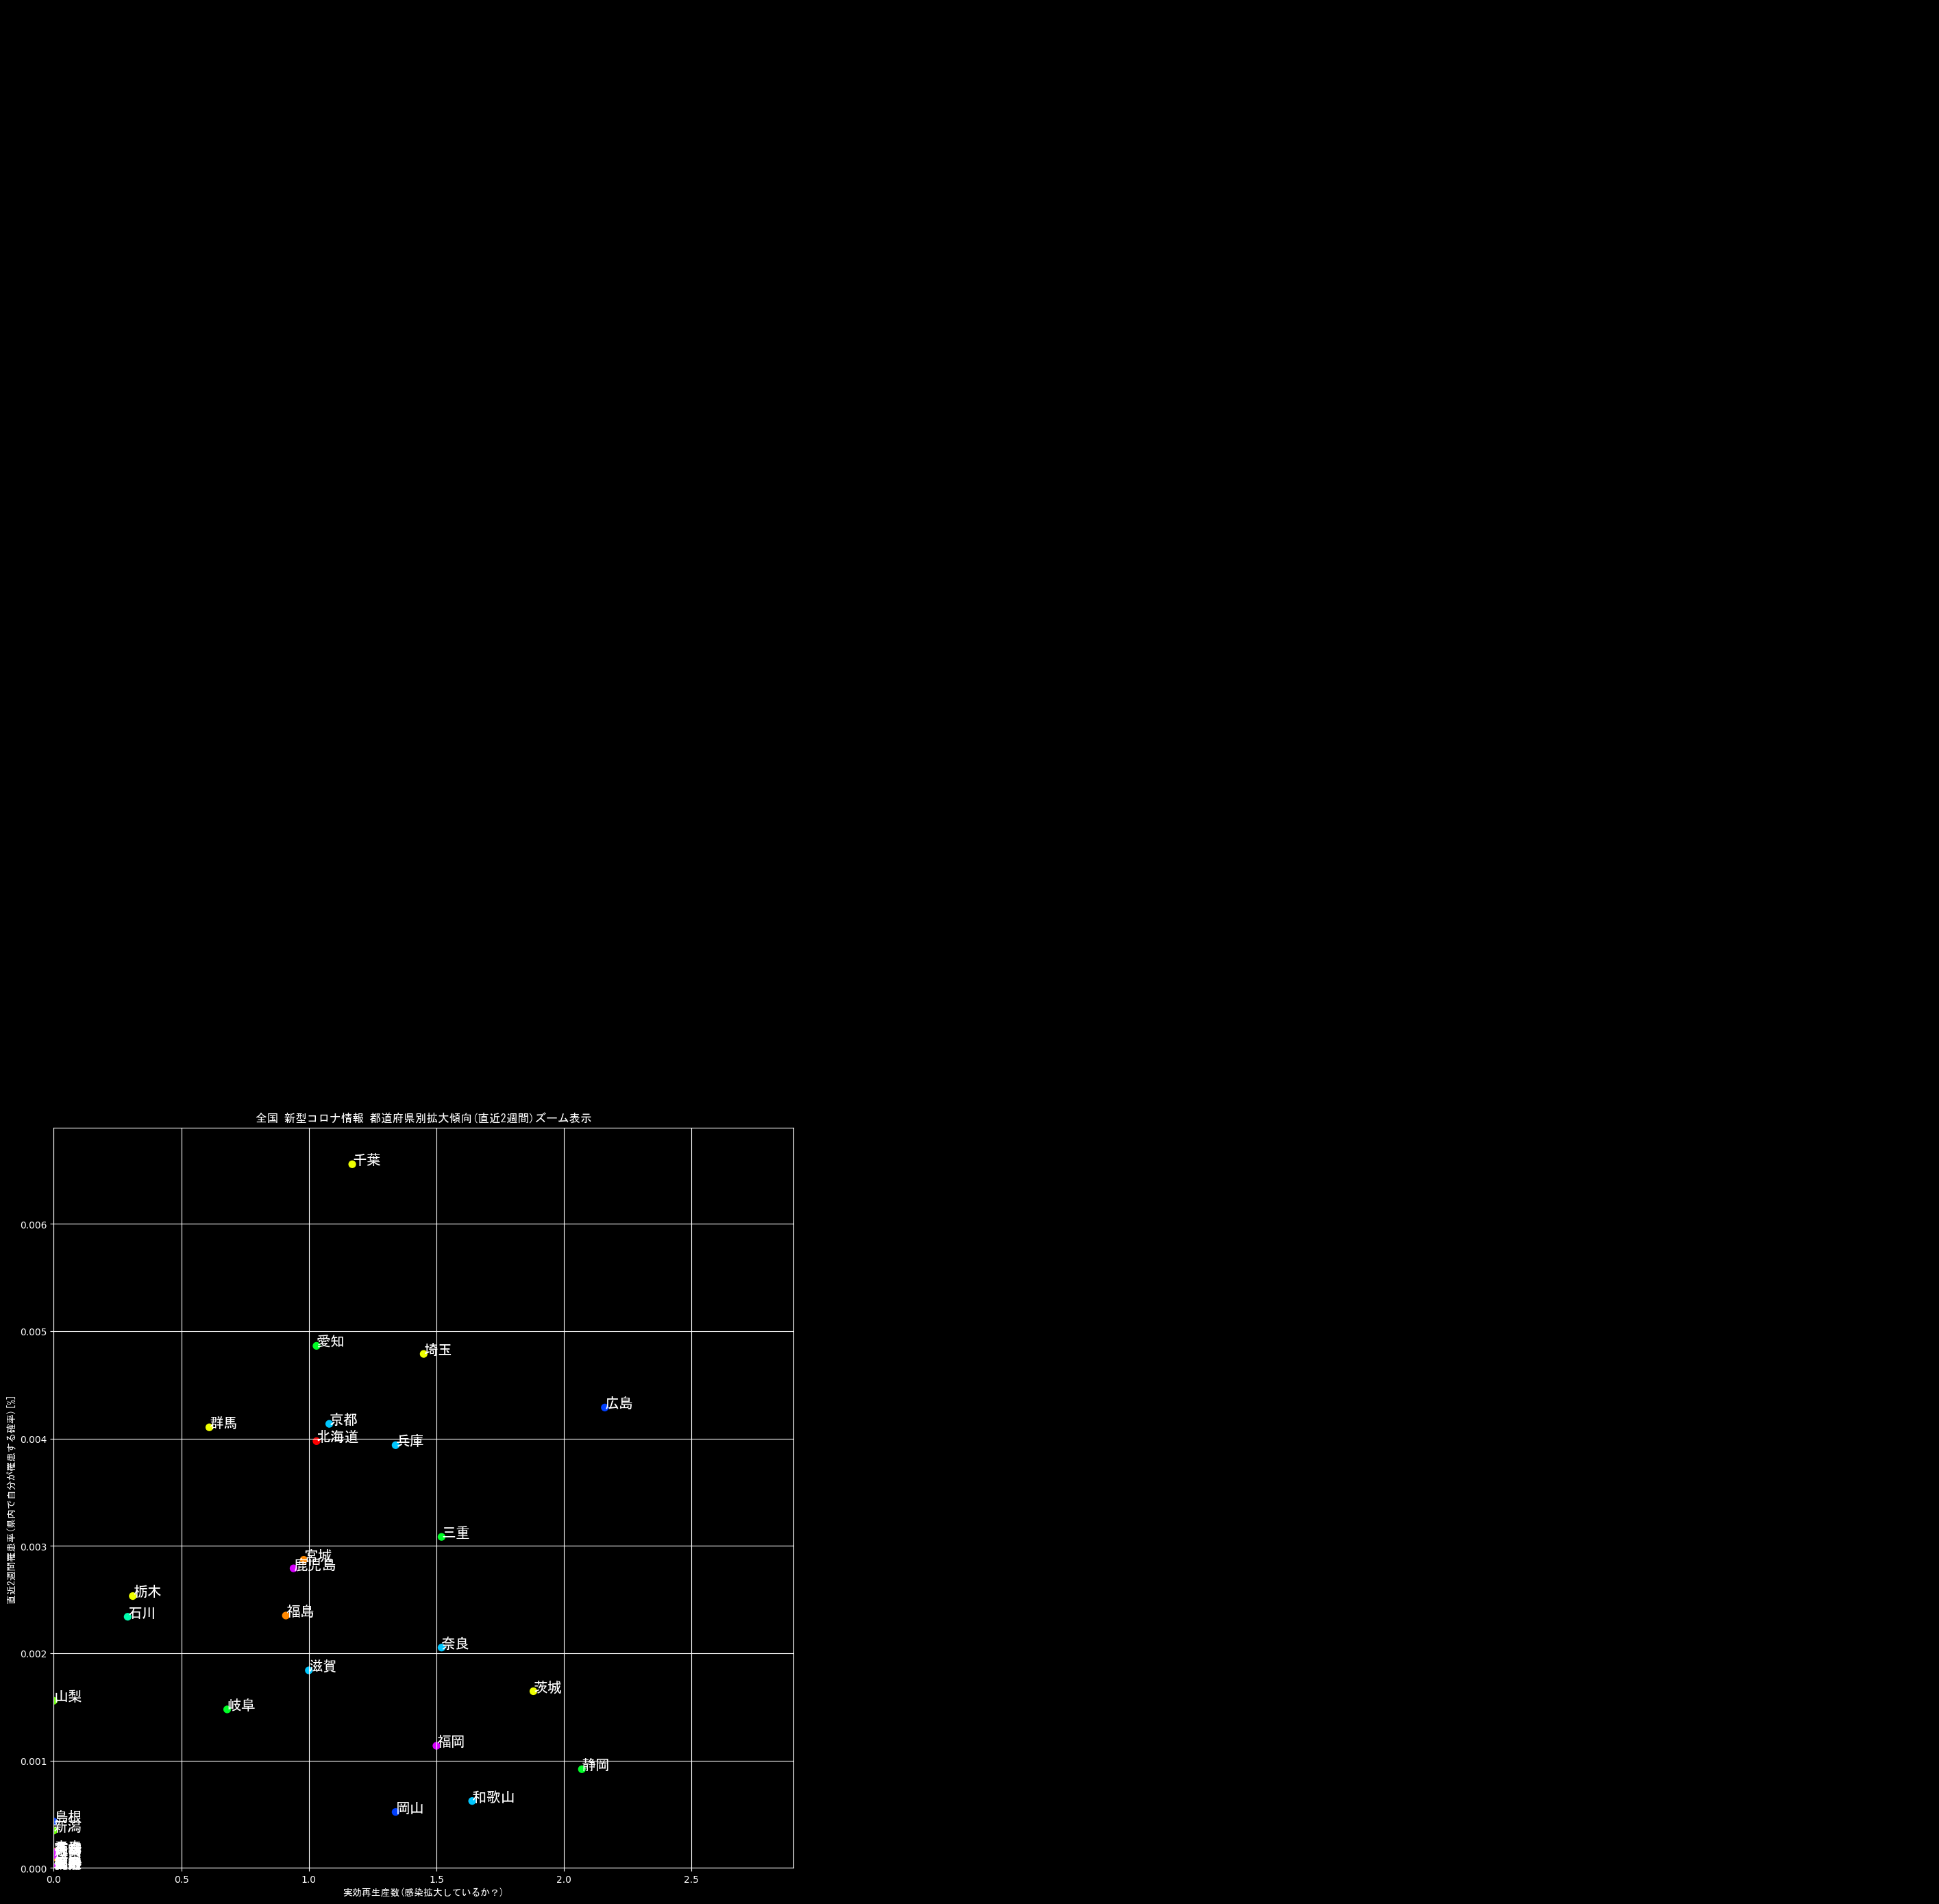

In [143]:
fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近2週間罹患率(県内で自分が罹患する確率)[%]")
plt.xlim(0, np.max(latest_erns[1:]) * 0.4)
plt.ylim(0, np.max(incid2w_rate[1:]) * 0.4)
plt.scatter(latest_erns[1:], incid2w_rate[1:], s=50, c=cols)
for i in range(n_states):
    ax.annotate(texts[i], xy=(latest_erns[1 + i], incid2w_rate[1 + i]), size=15, fontname=FONT_NAME)
tw_body_2w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)ズーム表示'
plt.title(tw_body_2w_zoom, fontname=FONT_NAME)
show_and_clear(fig, "ern-2w_poss-zoom.jpg")

In [144]:
def mak_japan_heatmap(filename, title, npa1d):
    plt.close()
    plt.style.use("dark_background")
    plt.subplots_adjust(left=0.07, right=0.99, bottom=0.07, top=0.95)
    plt.title(title, fontname=FONT_NAME)
    plt.rcParams['figure.figsize'] = 6, 6
    cmap = plt.get_cmap("Reds")
    norm = plt.Normalize(vmin=np.min(npa1d[1:]), vmax=np.max(npa1d[1:]))
    fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
    plt.colorbar(cm.ScalarMappable(norm, cmap))
    map_cols = {}
    for k, v in populations.items():
        map_cols[v['ja']] = fcol(npa1d[v['code']])
    pict = picture(map_cols)
    plt.imshow(pict)
    plt.savefig(filename)

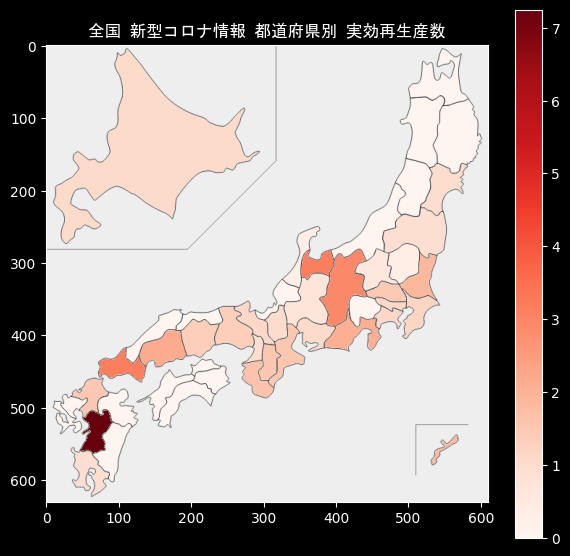

In [145]:
tw_body_map_erns = "全国 新型コロナ情報 都道府県別 実効再生産数"
mak_japan_heatmap('japan-erns.jpg', tw_body_map_erns, latest_erns)

In [146]:
#tw_body_map_1w = "全国 新型コロナ情報 都道府県別 直近1週間罹患率"
#mak_japan_heatmap('japan-1w.jpg', tw_body_map_1w, incid1w_rate)

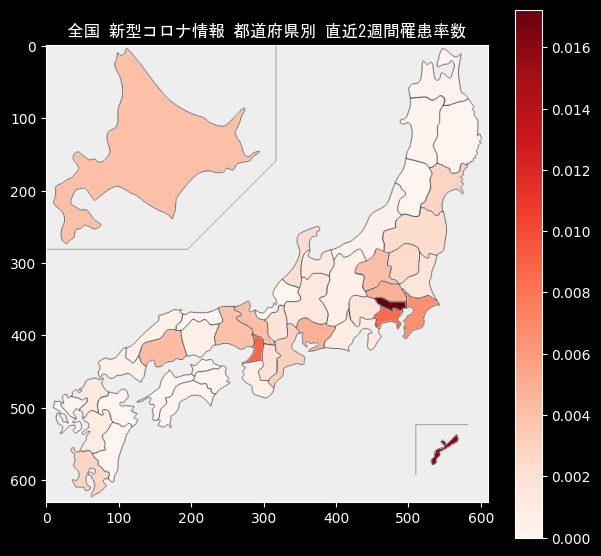

In [147]:
tw_body_map_2w = "全国 新型コロナ情報 都道府県別 直近2週間罹患率数"
mak_japan_heatmap('japan-2w.jpg', tw_body_map_2w, incid2w_rate)

In [148]:
tw = get_twitter()
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body_postfix = " (東洋経済 " + today_str + " 現在)"
#tweet_with_image(tw, "ern-1w_poss.jpg", tw_body_1w + tw_body_postfix)
#tweet_with_image(tw, "ern-1w_poss-zoom.jpg", tw_body_1w_zoom + tw_body_postfix)
tweet_with_image(tw, "ern-2w_poss.jpg", tw_body_2w + tw_body_postfix)
tweet_with_image(tw, "ern-2w_poss-zoom.jpg", tw_body_2w_zoom + tw_body_postfix)

In [149]:
tweet_with_image(tw, 'japan-erns.jpg', tw_body_map_erns + tw_body_postfix)
#tweet_with_image(tw, 'japan-1w.jpg', tw_body_map_1w + tw_body_postfix)
tweet_with_image(tw, 'japan-2w.jpg', tw_body_map_2w + tw_body_postfix)